# Exchange data between points and cells

Depending on the circumstances, data might naturally occur at the points or at the cells and you might want to transfer it from one to the other. The PolyMesh library provides a flexible facility to exchange data between points and cells using the concept of *nodal distribution factors*. First we set up a scene with a simple geometry, containing cells of all kinds:

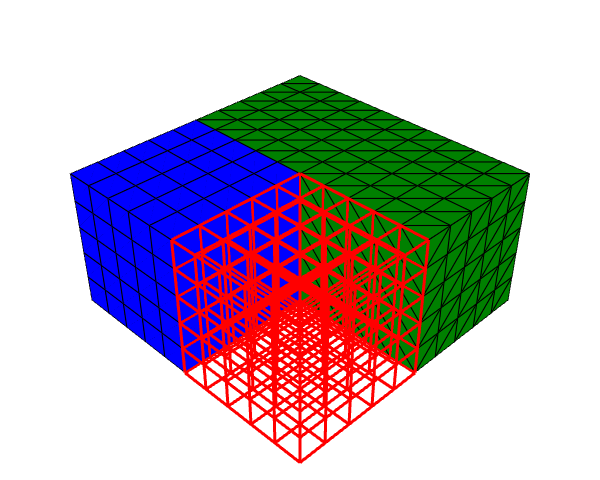

In [12]:
from polymesh import PolyData, PointData, LineData
from polymesh.space import CartesianFrame
from polymesh.grid import Grid
from polymesh.cells import H8, TET4, L2
from polymesh.utils.topology import H8_to_TET4, H8_to_L2
from polymesh.utils.space import frames_of_lines
import numpy as np

size = 10, 10, 5
shape = 10, 10, 5
grid = Grid(size=size, shape=shape, eshape='H8')
grid.centralize()

coords = grid.coords()
topo = grid.topology()
centers = grid.centers()

b_left = centers[:, 0] < 0
b_right = centers[:, 0] >= 0
b_front = centers[:, 1] >= 0
b_back = centers[:, 1] < 0
iTET4 = np.where(b_left)[0]
iH8 = np.where(b_right & b_back)[0]
iL2 = np.where(b_right & b_front)[0]
_, tTET4 = H8_to_TET4(coords, topo[iTET4])
_, tL2 = H8_to_L2(coords, topo[iL2])
tH8 = topo[iH8]

# crate supporting pointcloud
frame = CartesianFrame(dim=3)
pd = PointData(coords=coords, frame=frame)
mesh = PolyData(pd, frame=frame)

# tetrahedra
cdTET4 = TET4(topo=tTET4, frames=frame)
mesh['tetra'] = PolyData(cdTET4, frame=frame)
mesh['tetra'].config['A', 'color'] = 'green'

# hexahedra
cdH8 = H8(topo=tH8, frames=frame)
mesh['hex'] = PolyData(cdH8, frame=frame)
mesh['hex'].config['A', 'color'] = 'blue'

# lines
cdL2 = L2(topo=tL2, frames=frames_of_lines(coords, tL2))
mesh['line'] = LineData(cdL2, frame=frame)
mesh['line'].config['A', 'color'] = 'red'
mesh['line'].config['A', 'line_width'] = 3
mesh['line'].config['A', 'render_lines_as_tubes'] = True

# finalize the mesh and lock the layout
mesh.to_standard_form()
mesh.lock(create_mappers=True)

# plot with PyVista
mesh.plot(notebook=True, jupyter_backend='static', config_key=('A'),
          show_edges=True, window_size=(600, 480))

## Data from cells to points

Next we attach discrete data to the cells and make another plot. Since we only provided one scalar per cell, each cell is uniformly painted, without interpolation.

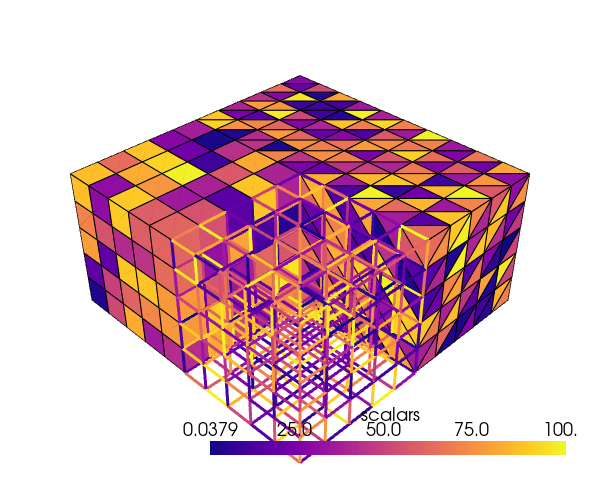

In [13]:
scalars_TET4 = 100*np.random.rand(len(cdTET4))
cdTET4.db['scalars'] = scalars_TET4

scalars_H8 = 100*np.random.rand(len(cdH8))
cdH8.db['scalars'] = scalars_H8

scalars_L2 = 100*np.random.rand(len(cdL2))
cdL2.db['scalars'] = scalars_L2
mesh['line'].config['B', 'render_lines_as_tubes'] = True
mesh['line'].config['B', 'line_width'] = 3

mesh.plot(notebook=True, jupyter_backend='static', config_key=('B'), 
          cmap='plasma', show_edges=True, window_size=(600, 480), 
          scalars='scalars')

To calculate the scalars of the points of the mesh from the values provided for the cells, use the `pull` method of the `PointData` of the block:

In [14]:
scalars = mesh.pd.pull('scalars')  # or simply pd.pull('scalars') 
scalars.shape, mesh.coords().shape

((726,), (726, 3))

We can use the calcualted values as the input to the plotting function:

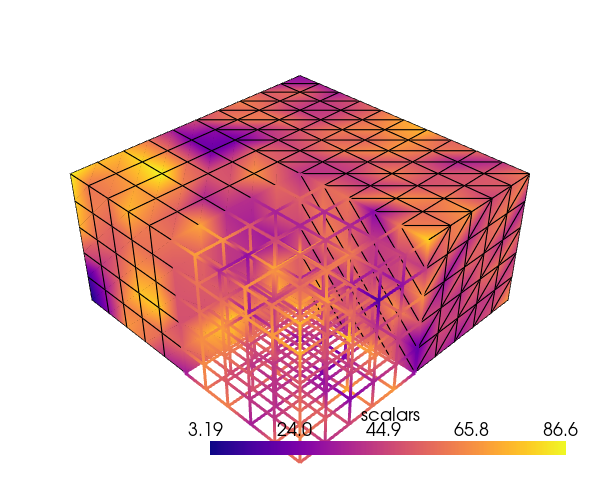

In [15]:
mesh.plot(notebook=True, jupyter_backend='static', config_key=('A'),
          show_edges=True, window_size=(600, 480), scalars=scalars, 
          cmap='plasma')

## Data from points to cells

The introduced mechanism works in both directions. No let say we define some data on the points:

In [16]:
scalars_on_points = 100*np.random.rand(len(coords))
mesh.pd.db['scalars'] = scalars_on_points

To transfer data from the points, use the `pull` method of a `CellData` instance:

In [17]:
hex_data = mesh['hex'].cd.pull('scalars')
hex_data.shape, mesh['hex'].topology().shape

((125, 8), (125, 8))

## Customizing the distribution mechanism

During the previous call to the `pull` method, nodal distribution factors were determined internally using the volumes of the cells as the governing measure. If you want more control, you can create your own distribution factors using custom weights. For example we can say that we use the volumes as the starting point, but we want to give the hex cells a bit more weight because the data calculated on them is considered to be more precise (which is true in some scenarios). To make the difference more pronounced, define a new dataset:

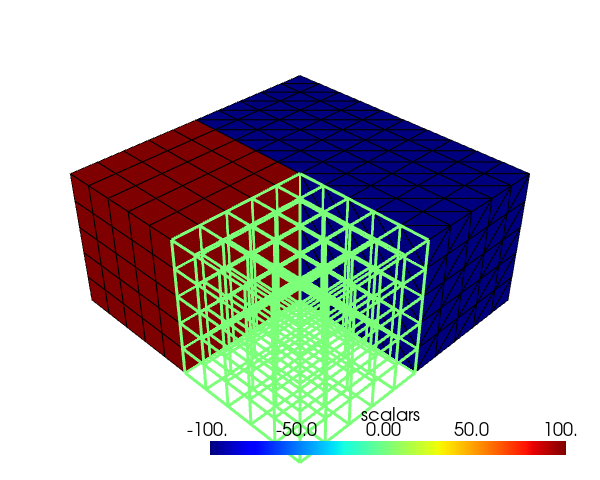

In [18]:
cdTET4.db['scalars'] = np.full(len(cdTET4), -100)
cdH8.db['scalars'] = np.full(len(cdH8), 100)
cdL2.db['scalars'] = np.full(len(cdL2), 0)
mesh.plot(notebook=True, jupyter_backend='static', config_key=('B'), 
          cmap='jet', show_edges=True, window_size=(600, 480), 
          scalars='scalars')

The default mechanism uses the volumes of the cells to determine nodal distribution factors:

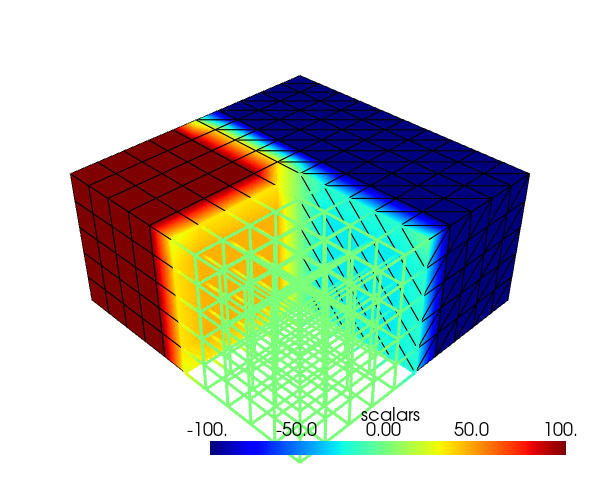

In [19]:
scalars = mesh.pd.pull('scalars')
mesh.plot(notebook=True, jupyter_backend='static', config_key=('A'),
          show_edges=True, window_size=(600, 480), scalars=scalars, 
          cmap='jet')

See how the results around hexahedral elements change if we give them more weight:

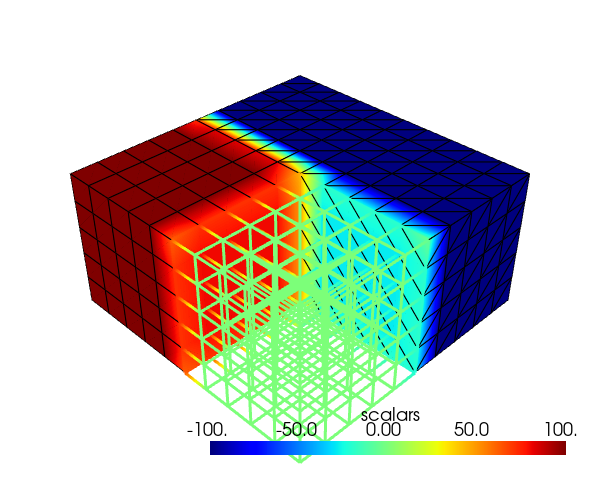

In [20]:
v = mesh.volumes()
idH8 = mesh['hex'].cd.id  # cell indices of hexahedra
v[idH8] *= 5  # 500% of original weight
ndf = mesh.nodal_distribution_factors(weights=v)
scalars = mesh.pd.pull('scalars', ndf=ndf)
mesh.plot(notebook=True, jupyter_backend='static', config_key=('A'),
          show_edges=True, window_size=(600, 480), scalars=scalars, 
          cmap='jet')

Making hexahedral cells less significant:

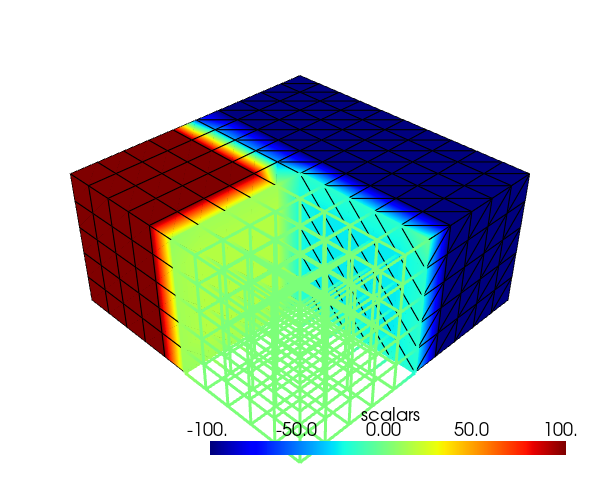

In [21]:
v = mesh.volumes()
idH8 = mesh['hex'].cd.id  # cell indices of hexahedra
v[idH8] /= 5  # 20% of original weight
ndf = mesh.nodal_distribution_factors(weights=v)
scalars = mesh.pd.pull('scalars', ndf=ndf)
mesh.plot(notebook=True, jupyter_backend='static', config_key=('A'),
          show_edges=True, window_size=(600, 480), scalars=scalars, 
          cmap='jet')